# Simulation of star PSF curve

- author : Sylvie Dagoret-Campagne
- afflilation : LAL-CNRS
- creation date : December 13th 2019



In [75]:
import os
import re
import numpy as np

In [76]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') # vary depending on your lang/locale

'en_US.UTF-8'

In [77]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
import matplotlib.cm as cmx

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

In [78]:
import numpy as np
import re
import time
from datetime import datetime,date
import dateutil.parser
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import Angle
from astropy import units as u
from astropy.table import Table

In [79]:
from math import ceil,floor
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
import astropy
from astropy.visualization.mpl_normalize import (ImageNormalize,MinMaxInterval,PercentileInterval,SqrtStretch,LogStretch)
from astropy.visualization.wcsaxes import SphericalCircle

In [80]:
from numpy.core._multiarray_umath import ndarray
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import probabilistic_hough_line
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter

In [81]:
matplotlib.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'lines.markersize': 15})
matplotlib.rcParams["axes.labelsize"]="small"
matplotlib.rcParams["axes.linewidth"]=2.0
matplotlib.rcParams["xtick.major.size"]=8
matplotlib.rcParams["ytick.major.size"]=8
matplotlib.rcParams["ytick.minor.size"]=5
matplotlib.rcParams["xtick.labelsize"]="large"
matplotlib.rcParams["ytick.labelsize"]="large"
matplotlib.rcParams["figure.figsize"]=(8,8)
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.titleweight'] = 'bold'
#matplotlib.rcParams['axes.facecolor'] = 'blue'
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
matplotlib.rcParams['lines.markersize'] = 10  # markersize, in points
matplotlib.rcParams['grid.alpha'] = 1. # transparency, between 0.0 and 1.0
matplotlib.rcParams['grid.linestyle'] = '-' # simple line
matplotlib.rcParams['grid.linewidth'] = 0.4 # in points 

# Definitions

## Addition includes

In [82]:
import sys
sys.path.append("../..")
sys.path.append("../../FeaturesExtractor")
sys.path.append("../../FeaturesExtractor/features")

In [83]:
from FeaturesExtractor.config import set_logger
from FeaturesExtractor.tools import *
from FeaturesExtractor import parameters

## Function

# Configuration

In [84]:
IMAGE_SIZE=200

In [85]:
THETA=45.*np.pi/180.

In [86]:
SIGMA_X=10
SIGMA_Y=6

In [87]:
X0=IMAGE_SIZE/2
Y0=IMAGE_SIZE/2

In [88]:
a=0.5*((np.cos(THETA)/SIGMA_X)**2+(np.sin(THETA)/SIGMA_Y)**2)

In [89]:
b=-np.sin(2*THETA)/4.*(-1./SIGMA_X**2 + 1./SIGMA_Y**2)

In [90]:
c=0.5*((np.sin(THETA)/SIGMA_X)**2+(np.cos(THETA)/SIGMA_Y)**2)

In [91]:
A=1000.

In [92]:
def PSF(x,y):
    return A*np.exp(-(a*(x-X0)**2 + 2*b*(y-Y0)*(x-X0) + c*(y-Y0)**2))

# Start

In [93]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

# Generate the image

In [94]:
background=np.random.normal(0,10,(IMAGE_SIZE,IMAGE_SIZE))

In [95]:
background-=background.min()

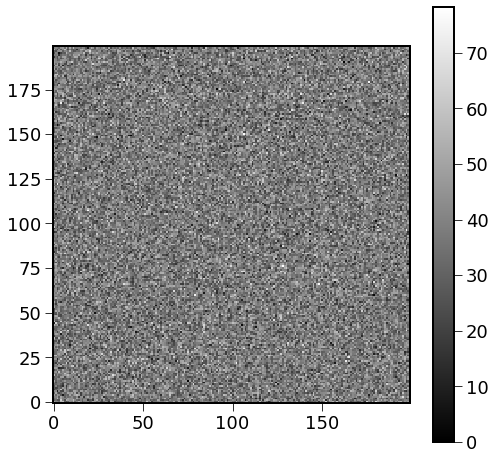

In [96]:
im=plt.imshow(background,origin="lower",cmap="gray")
plt.colorbar(im)

In [97]:
X=np.arange(IMAGE_SIZE)
Y=np.arange(IMAGE_SIZE)

In [98]:
XX, YY = np.meshgrid(X, Y)

In [99]:
signal=PSF(XX,YY)

In [100]:
image=signal+background

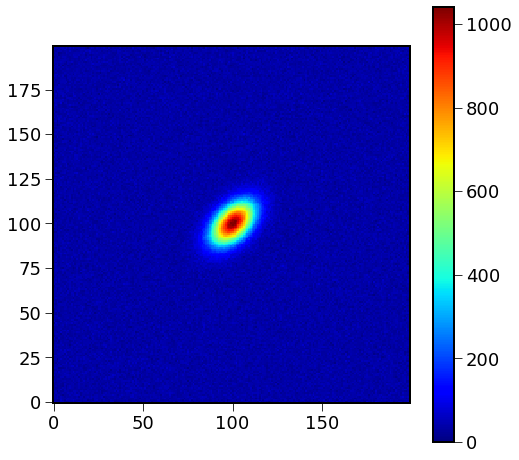

In [101]:
im=plt.imshow(image,origin="lower",cmap="jet")
plt.colorbar(im)

Text(0.5, 0.98, 'signal + background')

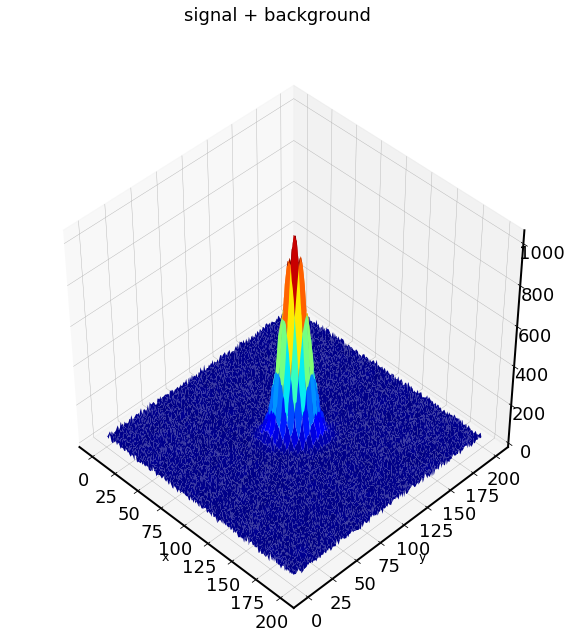

In [102]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(XX, YY, image, cmap="jet")
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.suptitle("signal + background")

# Compute the Hessian

In [103]:
lambda_plus, lambda_minus, theta = hessian_and_theta(image,margin_cut=1)

In [104]:
Nx=lambda_plus.shape[1]
Ny=lambda_plus.shape[0]

In [105]:
PadX=int((IMAGE_SIZE-Nx)/2)
PadY=int((IMAGE_SIZE-Ny)/2)

In [106]:
lambda_plus_new=np.zeros((IMAGE_SIZE,IMAGE_SIZE))
lambda_minus_new=np.zeros((IMAGE_SIZE,IMAGE_SIZE))

In [107]:
lambda_plus_new[PadY:IMAGE_SIZE-PadY, PadX:IMAGE_SIZE-PadX]= lambda_plus
lambda_minus_new[PadY:IMAGE_SIZE-PadY, PadX:IMAGE_SIZE-PadX]= lambda_minus

Text(0.5, 0.98, 'Lambda_plus')

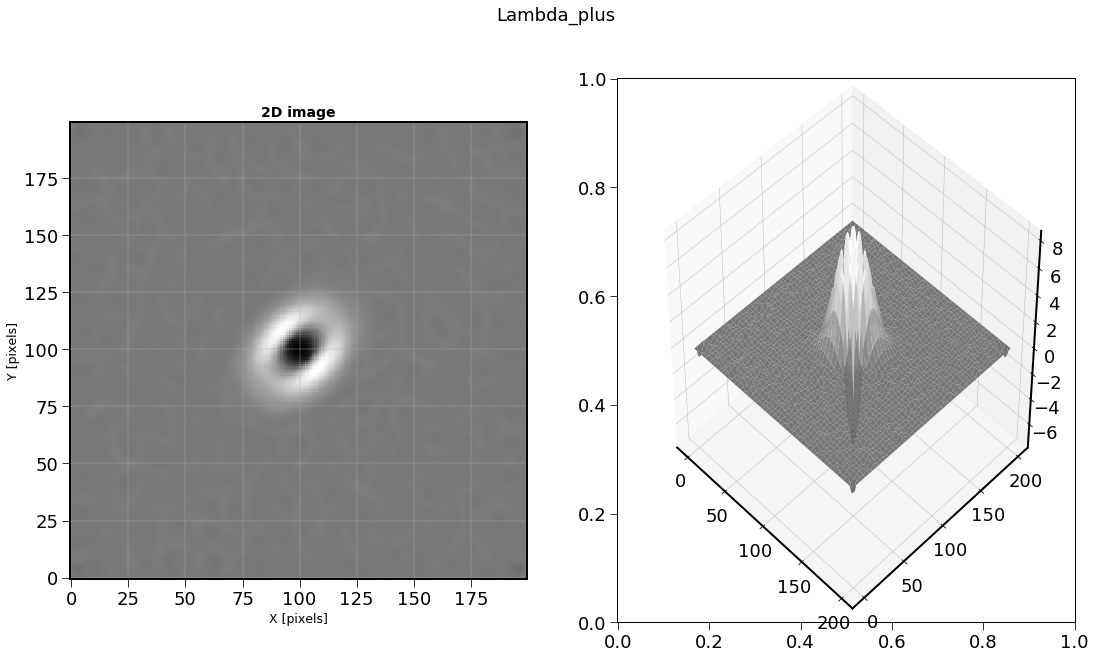

In [108]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))


ax1.imshow(lambda_plus_new, origin="lower", cmap=plt.cm.gray)
ax1.set_title('2D image', fontsize=14)
ax1.grid(True)
ax1.set_xlabel('X [pixels]')
ax1.set_ylabel('Y [pixels]')

ax2 = fig.add_subplot(122, projection='3d')
ax2.view_init(45, -45)
ax2.plot_surface(XX, YY, lambda_plus_new, cmap="gray")
        

# fig.tight_layout()
plt.suptitle("Lambda_plus",fontsize=18)


Text(0.5, 0.98, 'Lambda_minus')

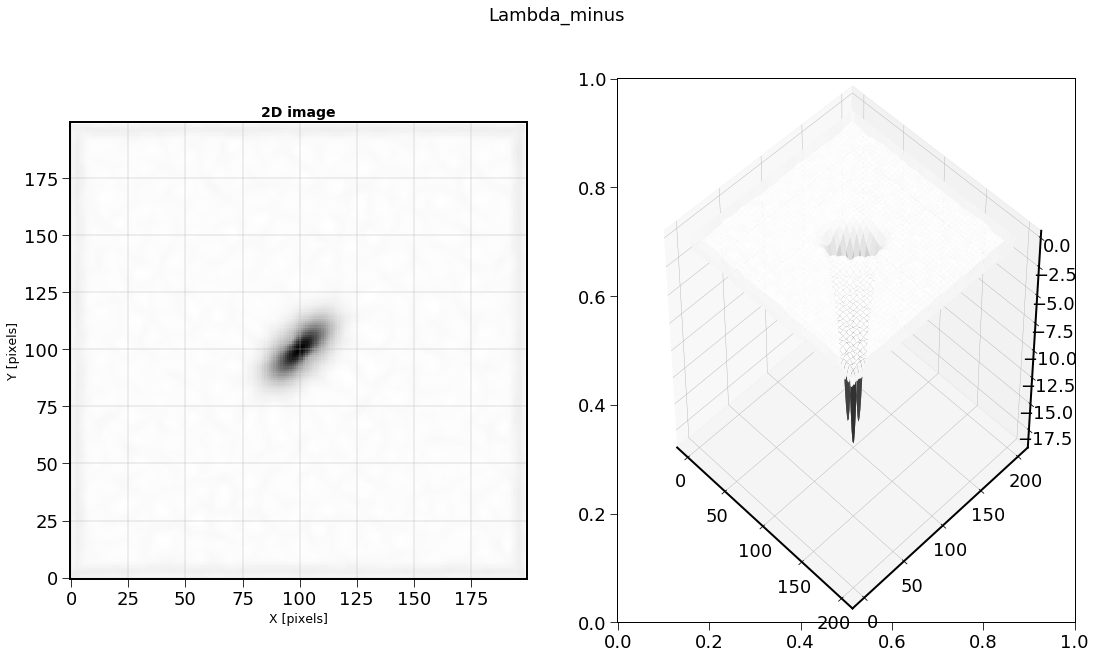

In [109]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))


ax1.imshow(lambda_minus_new, origin="lower", cmap=plt.cm.gray)
ax1.set_title('2D image', fontsize=14)
ax1.grid(True)
ax1.set_xlabel('X [pixels]')
ax1.set_ylabel('Y [pixels]')

ax2 = fig.add_subplot(122, projection='3d')
ax2.view_init(45, -45)
ax2.plot_surface(XX, YY, lambda_minus_new, cmap="gray")
        

# fig.tight_layout()
plt.suptitle("Lambda_minus",fontsize=18)

# detect the edges

In [110]:
lambda_plus_edge=feature.canny(lambda_plus_new, sigma=5)
lambda_minus_edge=feature.canny(lambda_minus_new, sigma=5)

Text(0.5, 0.98, 'Canny edge detection')

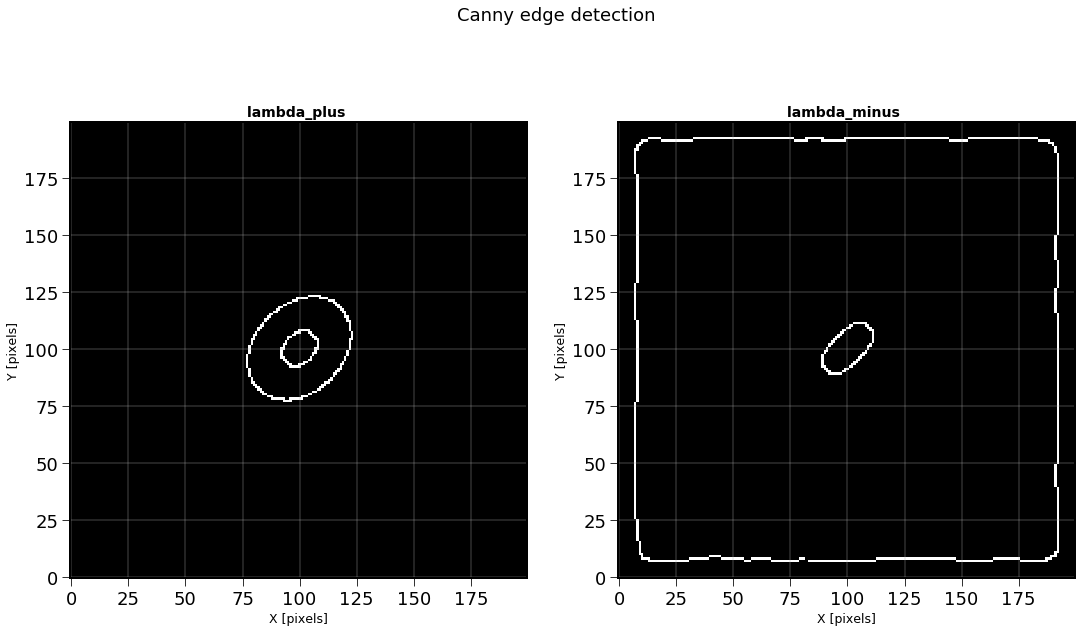

In [111]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))


ax1.imshow(lambda_plus_edge, origin="lower", cmap=plt.cm.gray)
ax1.set_title('lambda_plus ', fontsize=14)
ax1.grid(True)
ax1.set_xlabel('X [pixels]')
ax1.set_ylabel('Y [pixels]')

ax2.imshow(lambda_minus_edge, origin="lower", cmap=plt.cm.gray)
ax2.set_title('lambda_minus ', fontsize=14)
ax2.grid(True)
ax2.set_xlabel('X [pixels]')
ax2.set_ylabel('Y [pixels]')
        

# fig.tight_layout()
plt.suptitle("Canny edge detection",fontsize=18)